In [39]:
from hmmlearn.hmm import GMMHMM
import numpy as np
import pandas as pd
from pyhhmm.heterogeneous import HeterogeneousHMM
from matplotlib import pyplot as plt
import pyhhmm.utils as ut
import kagglehub
import matplotlib.colors as mcolors

In [8]:
def separate_games(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separate dataframe into separate games via the game ID. Place into a 
    list of games. Indices are reindexed so plays are numbered, starting with 0
    """
    games = [df[df['GameID'] == value].reset_index(drop=True) for value in df['GameID'].unique()]
        
    return games

def separate_years(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separates the games by which season in which they occured. Outputs a list of seasons."""
    seasons = [df[df['Season'] == value].reset_index(drop=True) for value in df['Season'].unique()]
    
    return seasons

def calculate_time_per_play(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the time each play took.
    Kicks will have NANs in the new play_time column, which should make them easy to remove
    """
    game['play_time'] = -game['TimeSecs'].diff()

    return game


def drop_unnecessary_rows(game: pd.DataFrame) -> pd.DataFrame:
    """The end of each quarter is its own row. Same with timeouts
    and the end of the game. Other values are mostly NANs.
    This removes all of those unhelpful rows and reindexes

    NOTE: plays must be indexed starting with their first play
    TODO: Might be able to just drop rows with missing posteam
    """
    # find indices
    game.dropna(subset=['posteam', 'play_time'], inplace=True)
    # reset index
    game = game.reset_index(drop=True)

    return game

def encode_teams(game: pd.DataFrame) -> pd.DataFrame:
    """Change all team names to just 0s or 1s. This won't be retraceable if you are
    looking for a game with a specific team playing.
    """
    teams = game['posteam'].unique()
    if len(teams) != 2:
        print(teams)
        raise ValueError("Dataset has not been properly cleaned. There are more than 2 values in posteam.")
    
    home_team = game["HomeTeam"][0]
    team_map = {team:0 if team == home_team else 1 for team in teams} # NOTE: this now marks the home team as team 0
    game['posteam'] = game['posteam'].map(team_map)
    game['DefensiveTeam'] = game['DefensiveTeam'].map(team_map)

    return game

def create_team0_yardage(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the yards gained in the play by team zero. 
    It is negative if team 1 is in posession and gains yards.
    """
    game['hometeam_yards'] = np.where(game['posteam'] == 0, game['Yards.Gained'], -game['Yards.Gained'])

    return game

def no_overtime(game: pd.DataFrame) -> pd.DataFrame:
    """Discard all data on overtime periods. 
    Will result in another Dataframe
    """
    game = game[game["qtr"]!=5]
    return game
    

# Of note: Yards.Gained
# TODO: column of yards gained for team 0, when team 1 gains yards, value is negative
# TODO: keep nans in until you calculate time per play
#   then delete those rows like before and replace nans in time per play with
#   average time per play in that game

In [4]:
# Download latest version
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")

print("Path to dataset files:", path)

Path to dataset files: /Users/henryfetzer/.cache/kagglehub/datasets/maxhorowitz/nflplaybyplay2009to2016/versions/6


In [ ]:
df = pd.read_csv(path + "/NFL Play by Play 2009-2016 (v3).csv")

# split seasons
seasons = separate_years(df)

# split games from season 1
season = seasons[1]
games = separate_games(season)

# clean all games
for i, game in enumerate(games):
    games[i] = no_overtime(game)
    games[i] = calculate_time_per_play(game)
    games[i] = drop_unnecessary_rows(games[i])
    games[i] = encode_teams(games[i])
    games[i] = create_team0_yardage(games[i])
    games[i] = no_overtime(games[i]) # new

# recombine
df = pd.concat(games, ignore_index=True)

# choose game 50 for no particular reason
game = games[50]

/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_8743/2210080071.py:1: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/NFL Play by Play 2009-2016 (v3).csv")


In [34]:
columns_to_keep = ['hometeam_yards', 'play_time', 'posteam', 'Yards.Gained', 'qtr']
reduced_game = game.loc[:, columns_to_keep]

# Create observations
first_half = reduced_game[reduced_game['qtr'].isin([1, 2])]
second_half = reduced_game[reduced_game['qtr'].isin([3, 4])]
second_posessions = second_half.loc[:, 'posteam']
observations = first_half.loc[:, ['Yards.Gained', 'posteam']].to_numpy()
print(observations.shape)

(74, 2)


## Try the Heterogeneous HMM

In [22]:
# Initialize the model
my_hmm = HeterogeneousHMM(
    n_states=4, # experiment with this
    n_g_emissions=1,   # number of continuous observations
    n_d_emissions=1,    # number of discrete observations
    n_d_features=[2],    # number of possible values for each discrete variable
    covariance_type="diagonal",
    verbose=True
    )

# Train
my_hmm, log_likelihood = my_hmm.train([observations], n_init=10, n_iter=10)

Initialisation 1


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -328.42166969501113, delta = nan
iter: 1, log_likelihood = -281.04303098659796, delta = 47.37863870841318
iter: 2, log_likelihood = -279.908093737883, delta = 1.134937248714948
iter: 3, log_likelihood = -279.01329174535437, delta = 0.8948019925286417
iter: 4, log_likelihood = -278.41288375728, delta = 0.6004079880743802
iter: 5, log_likelihood = -277.63768157022054, delta = 0.775202187059449
iter: 6, log_likelihood = -276.5290448068383, delta = 1.1086367633822647
Converged -> iter: 6, log_likelihood = -276.5290448068383
Initialisation 2


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -339.62840271367986, delta = nan
iter: 1, log_likelihood = -282.1684367015681, delta = 57.45996601211175
iter: 2, log_likelihood = -275.8916179539282, delta = 6.276818747639936
iter: 3, log_likelihood = -270.1080747640168, delta = 5.78354318991137
iter: 4, log_likelihood = -267.01748609826086, delta = 3.090588665755945
iter: 5, log_likelihood = -264.49737105123506, delta = 2.520115047025797
iter: 6, log_likelihood = -262.3620989766439, delta = 2.135272074591171
Converged -> iter: 6, log_likelihood = -262.3620989766439
Initialisation 3


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -318.75824484963863, delta = nan
iter: 1, log_likelihood = -283.85685668383576, delta = 34.90138816580287
iter: 2, log_likelihood = -281.8190898546341, delta = 2.0377668292016438
iter: 3, log_likelihood = -280.6872947489567, delta = 1.1317951056774405
iter: 4, log_likelihood = -279.90590965620885, delta = 0.7813850927478256
iter: 5, log_likelihood = -279.0215018078534, delta = 0.8844078483554654
iter: 6, log_likelihood = -278.2320872562192, delta = 0.789414551634195
Converged -> iter: 6, log_likelihood = -278.2320872562192
Initialisation 4


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -345.9900756854706, delta = nan
iter: 1, log_likelihood = -283.34031172953115, delta = 62.64976395593942
iter: 2, log_likelihood = -280.5744170637371, delta = 2.7658946657940646
iter: 3, log_likelihood = -278.19649126569, delta = 2.3779257980471016
iter: 4, log_likelihood = -274.47383356969397, delta = 3.72265769599602
iter: 5, log_likelihood = -269.69297316769655, delta = 4.7808604019974155
iter: 6, log_likelihood = -267.22661089548524, delta = 2.466362272211313
Converged -> iter: 6, log_likelihood = -267.22661089548524
Initialisation 5


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -328.40561303836137, delta = nan
iter: 1, log_likelihood = -282.71967083424397, delta = 45.685942204117396
iter: 2, log_likelihood = -280.8543501999545, delta = 1.8653206342894464
iter: 3, log_likelihood = -279.472916839099, delta = 1.3814333608555103
iter: 4, log_likelihood = -278.5939568284187, delta = 0.8789600106803164
iter: 5, log_likelihood = -277.6481204859415, delta = 0.9458363424772074
iter: 6, log_likelihood = -276.07387184610116, delta = 1.5742486398403344
Converged -> iter: 6, log_likelihood = -276.07387184610116
Initialisation 6


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -354.9981558737592, delta = nan
iter: 1, log_likelihood = -281.5200292615877, delta = 73.47812661217148
iter: 2, log_likelihood = -279.83820412044935, delta = 1.6818251411383471
iter: 3, log_likelihood = -278.66654331215034, delta = 1.1716608082990092
iter: 4, log_likelihood = -277.49493571337666, delta = 1.1716075987736758
iter: 5, log_likelihood = -275.9692835856425, delta = 1.5256521277341903
iter: 6, log_likelihood = -273.69083974639005, delta = 2.278443839252418
Converged -> iter: 6, log_likelihood = -273.69083974639005
Initialisation 7


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -311.35783792510597, delta = nan
iter: 1, log_likelihood = -283.99263507267847, delta = 27.3652028524275
iter: 2, log_likelihood = -281.92691793078643, delta = 2.065717141892037
iter: 3, log_likelihood = -280.64118801214335, delta = 1.285729918643085
iter: 4, log_likelihood = -279.47793460081425, delta = 1.1632534113290944
iter: 5, log_likelihood = -278.3371728901941, delta = 1.1407617106201542
Converged -> iter: 5, log_likelihood = -278.3371728901941
Initialisation 8


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -310.9483130698668, delta = nan
iter: 1, log_likelihood = -284.84736323012646, delta = 26.100949839740338
iter: 2, log_likelihood = -282.7475644171948, delta = 2.099798812931681
iter: 3, log_likelihood = -281.5629307110245, delta = 1.1846337061703025
iter: 4, log_likelihood = -280.5608309539944, delta = 1.0020997570300665
iter: 5, log_likelihood = -279.5717290328137, delta = 0.9891019211806906
Converged -> iter: 5, log_likelihood = -279.5717290328137
Initialisation 9


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -316.2793443404582, delta = nan
iter: 1, log_likelihood = -281.4057257011037, delta = 34.873618639354504
iter: 2, log_likelihood = -279.6300184794048, delta = 1.7757072216988945
iter: 3, log_likelihood = -278.5241800639553, delta = 1.1058384154494547
iter: 4, log_likelihood = -277.2753568827726, delta = 1.248823181182729
iter: 5, log_likelihood = -275.79962441826217, delta = 1.475732464510429
iter: 6, log_likelihood = -273.96318058100996, delta = 1.8364438372522045
Converged -> iter: 6, log_likelihood = -273.96318058100996
Initialisation 10


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -339.00365606912857, delta = nan
iter: 1, log_likelihood = -282.5110835112018, delta = 56.49257255792679
iter: 2, log_likelihood = -279.90464518844584, delta = 2.6064383227559347
iter: 3, log_likelihood = -278.3061901857489, delta = 1.5984550026969373
iter: 4, log_likelihood = -275.68624624028786, delta = 2.6199439454610456
iter: 5, log_likelihood = -271.1419709887199, delta = 4.544275251567967
iter: 6, log_likelihood = -267.6458630385242, delta = 3.4961079501956647
Converged -> iter: 6, log_likelihood = -267.6458630385242


## Check results of the model on second half

-262.3620989766439


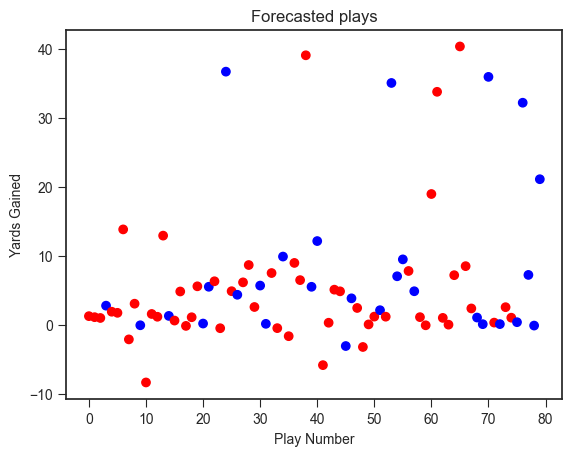

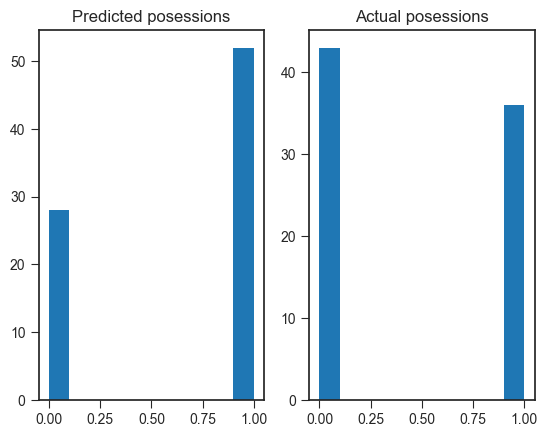

[1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1
 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1
 1 0 0 0 0 0]


In [42]:
print(log_likelihood)

# Forecast the rest of the game
samples = my_hmm.sample(n_samples=80)
forecast = samples[0]
pred_pos = forecast[:,1].astype(int)





# Add a custom colormap
custom_cmap = mcolors.ListedColormap(['blue', 'red'])

# Plot
plt.title("Forecasted plays")
scatter = plt.scatter(np.arange(len(forecast)), forecast[:,0], c=pred_pos, cmap=custom_cmap)
plt.xlabel("Play Number")
plt.ylabel("Yards Gained")
plt.show()

# Compare with actual
plt.subplot(121)
plt.title("Predicted posessions")
plt.hist(forecast[:,1].astype(int))

plt.subplot(122)
plt.title("Actual posessions")
plt.hist(second_posessions.to_numpy().astype(int))

plt.show()

print(forecast[:,1].astype(int))